### Simple Deep learning Model 

#### 1. Importing the necessary import

In [53]:
import os
from os import listdir
from os.path import isfile, join
from glob import glob

import random
import numpy as np
import pandas as pd
from tqdm import tqdm 

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

# from IPython.core.display import display, HTML
# from IPython.display import display
# display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# %autoreload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Please install GPU version of TF")

2023-07-18 14:54:12.194825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


2023-07-18 14:54:14.968442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 14:54:14.974822: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


2023-07-18 14:54:15.202924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 14:54:15.204495: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### 2. Loading the dataset

In [4]:
from sklearn.datasets import fetch_lfw_people
lfw_dataset = fetch_lfw_people(min_faces_per_person=70,color=True)

In [5]:
X = lfw_dataset.images
y = lfw_dataset.target

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_test = label_as_binary.fit_transform(y_test)

In [13]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

#### 3. Preparing the model 

In [16]:
def create_simple_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(3, 3))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(64, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)        
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

In [17]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

In [19]:
batch_size = 40

model_path = os.path.join("weights", "image_classification.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

# train_gen = generator.get_batch(batch_size, is_augmented=True, validation=False)
# test_gen = generator.get_batch(400, is_augmented=False, validation=True)

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

# batch_img, _ = next(train_gen)
simple_model = create_simple_model((62,47,3), 7)
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
simple_model.summary()                                                                            

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 47, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 45, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 20, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 20, 15, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 9600)              0     

In [101]:
# model_path = os.path.join("weights", "image_classification.hd5")
# simple_model = load_model(model_path)
# simple_model.summary()

#### 4. Running the model

In [83]:
history = simple_model.fit(
    X_train, y_train,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test,y_test),
    epochs=100,
    verbose=1,
    callbacks=[reduceLROnPlato, checkPoint, earlyStop]
)

Epoch 1/100
31/32 [============================>.] - ETA: 0s - loss: 0.0947 - accuracy: 0.9687
Epoch 1: val_loss did not improve from 0.45067
32/32 [==============================] - 2s 69ms/step - loss: 0.0941 - accuracy: 0.9689 - val_loss: 0.5312 - val_accuracy: 0.8605 - lr: 0.0050
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9748
Epoch 2: val_loss improved from 0.45067 to 0.40219, saving model to weights/arcface_weights.hd5


INFO:tensorflow:Assets written to: weights/arcface_weights.hd5/assets


INFO:tensorflow:Assets written to: weights/arcface_weights.hd5/assets


32/32 [==============================] - 4s 114ms/step - loss: 0.0667 - accuracy: 0.9748 - val_loss: 0.4022 - val_accuracy: 0.9109 - lr: 0.0050
Epoch 3/100
31/32 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9717
Epoch 3: val_loss did not improve from 0.40219
32/32 [==============================] - 2s 74ms/step - loss: 0.0771 - accuracy: 0.9718 - val_loss: 0.4969 - val_accuracy: 0.8837 - lr: 0.0050
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9660
Epoch 4: val_loss did not improve from 0.40219
32/32 [==============================] - 2s 75ms/step - loss: 0.0833 - accuracy: 0.9660 - val_loss: 0.6484 - val_accuracy: 0.8527 - lr: 0.0050
Epoch 5/100
31/32 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9765
Epoch 5: val_loss did not improve from 0.40219
32/32 [==============================] - 2s 74ms/step - loss: 0.0723 - accuracy: 0.9767 - val_loss: 0.4153 - val_accuracy: 0.9225 - lr: 0.0050
E

#### 5. Evaluation

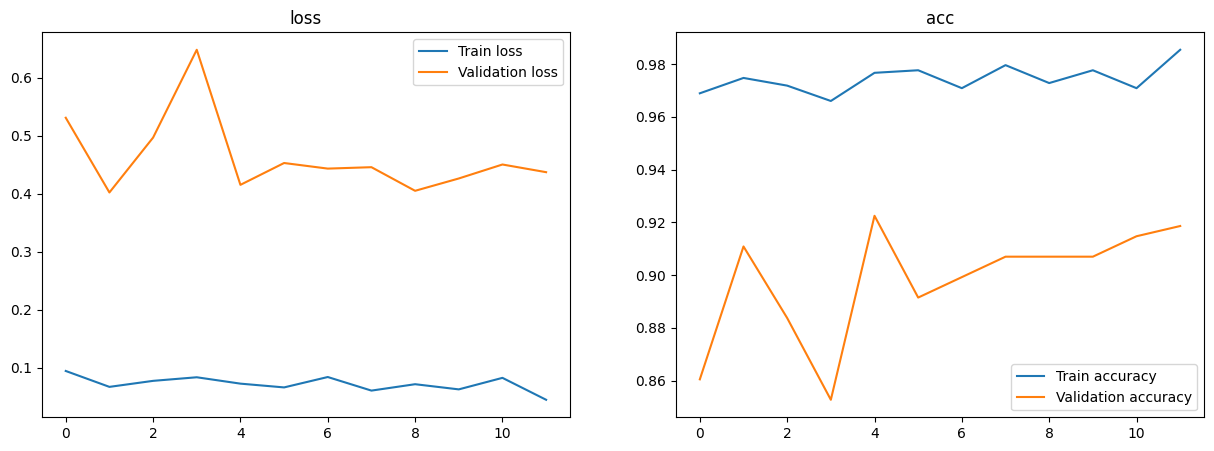

In [84]:
show_history(history)

In [85]:
from sklearn.metrics import confusion_matrix, classification_report

predict_idxs = simple_model.predict(X_test, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

y_test = label_as_binary.fit_transform(y_test)

cm = confusion_matrix(np.argmax(y_test, axis=1), predict_idxs)
print(cm)

9/9 [==============================] - 0s 10ms/step
[[  8   0   2   0   0   0   1]
 [  1  45   0   1   0   0   0]
 [  2   0  19   0   0   0   1]
 [  0   1   4 113   1   0   0]
 [  0   1   0   0  18   0   0]
 [  0   1   0   0   1  11   0]
 [  0   1   0   1   2   0  23]]


In [87]:
target = lfw_dataset.target
target_names = lfw_dataset.target_names

In [88]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [89]:
print(classification_report(np.argmax(y_test, axis=1), predict_idxs, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.73      0.73        11
     Colin Powell       0.92      0.96      0.94        47
  Donald Rumsfeld       0.76      0.86      0.81        22
    George W Bush       0.98      0.95      0.97       119
Gerhard Schroeder       0.82      0.95      0.88        19
      Hugo Chavez       1.00      0.85      0.92        13
       Tony Blair       0.92      0.85      0.88        27

         accuracy                           0.92       258
        macro avg       0.88      0.88      0.87       258
     weighted avg       0.92      0.92      0.92       258

